One of Telco's main problems is customer churn. Is it possible to predict that the customer will churn before the churn happens?
----




In [195]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, \
                            precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [148]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Load Data
-----

In [173]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [176]:
print(f"The dataset has a total of {len(df)} rows.")

The dataset has a total of 7043 rows.


Split train-test
-----

We are going to use 20% of the dataset for testing purposes.

In [ ]:
X = df[df.columns[:-1]]  # keep all the features columns
y = df[df.columns[-1]]  # target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Fit scikit-learn model
----

#### 
- To approach this problem we decided to fit two different models. Random Forest and Gradient Boosting. 
- For searching the best hyperparameters we defined one different grid for each model and applied Randomize search to choose the best ones.
- We divide categorical and continuous features and apply a different type of preprocessing to each of them.

#### What metrics did we choose? Why? 

- We chose two different metrics to decide which model is the best one; F1 score and average precision recall, as false positive (FP) and false negative (FN) are crucial. Specially the latter.

#### Separate the columns type 

In [ ]:
continuous_columns = ['MonthlyCharges', 'TotalCharges']

categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                       'PaymentMethod']

#### Define the parameters grid for both models

In [ ]:
param_grid_rf = {'model__max_features': ["sqrt", "log2"],
              'model__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'model__max_depth': [None, 1, 2, 3, 5, 7, 8, 9, 10],
              'model__n_estimators': [100, 120, 140, 160, 180, 200, 220, 240, 260, 280]
             }

param_grid_gb = {'model__max_features': ["sqrt", "log2"],
              'model__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'model__max_depth': [None, 1, 2, 3, 5, 7, 8, 9, 10],
              'model__loss': ["deviance", "exponential"],
              'model__min_samples_split': [1, 2, 3, 5, 7, 8, 9, 10],
              'model__n_estimators': [100, 120, 140, 160, 180, 200, 220, 240, 260, 280]
             }

#### Fit the different pipelines and search the best hyperparams using RandomizedSearchCV

The F1 score for RandomForestClassifier(class_weight={0: 1, 1: 10}) is: 0.55
The average_precision_recall score for RandomForestClassifier is: 0.62
The best params for RandomForestClassifier are: 
{'model__n_estimators': 260, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': None}
------------------------------------------------------------
The F1 score for GradientBoostingClassifier() is: 0.58
The average_precision_recall score for GradientBoostingClassifier is: 0.65
The best params for GradientBoostingClassifier are: 
{'model__n_estimators': 220, 'model__min_samples_split': 7, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 2, 'model__loss': 'deviance'}
------------------------------------------------------------


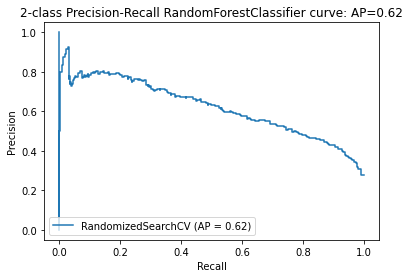

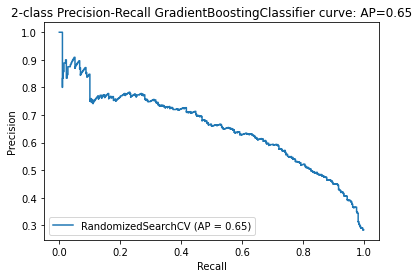

In [237]:
models = [(RandomForestClassifier(class_weight={0:1,1:10}), param_grid_rf), 
          (GradientBoostingClassifier(), param_grid_gb)]

# turn labels from 'No', 'Yes' to [0,1]
le = LabelEncoder()
le.fit(y_train)


cat_pipe = Pipeline([('OHE', OneHotEncoder(handle_unknown='ignore'))])

continuous_pipe = Pipeline([('HandleMissing', SimpleImputer(strategy='mean')), 
                            ('scaler', StandardScaler())
                           ])

preprocess = ColumnTransformer([('categorical', cat_pipe, categorical_columns),
                                ('continuous', continuous_pipe, continuous_columns)
                               ])
all_models = []
for model, param_grid in models:
    pipe = Pipeline([('preprocessing', preprocess),
                     ('model', model)
                    ])

    random_cv = RandomizedSearchCV(estimator = pipe,
                                   param_distributions=param_grid,
                                   n_iter = 125,
                                   cv=5,
                                   n_jobs=-1)

    random_cv.fit(X_train, le.transform(y_train))
    all_models.append(random_cv) #  Save model for later
    y_pred = random_cv.predict(X_test)
    y_score = random_cv.predict_proba(X_test)
    
    score = f1_score(y_pred, le.transform(y_test))
    print(f"The F1 score for {model} is: %.{2}f" % score)

    model_name = type(model).__name__
    average_precision = average_precision_score(le.transform(y_test), y_score[:, 1])
    print(f"The average_precision_recall score for {model_name} is: %.{2}f" % average_precision)
    print(f"The best params for {model_name} are: \n{random_cv.best_params_}")
    
    disp = plot_precision_recall_curve(random_cv, X_test, le.transform(y_test))
    disp.ax_.set_title("2-class Precision-Recall {0} curve: AP={1:0.2f}".format(model_name, average_precision));
    print("------------------------------------------------------------")

#### The best model is Gradient Boosting Classifier with the following parameters:
{'model__n_estimators': 220, 'model__min_samples_split': 7, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 2, 'model__loss': 'deviance'}

In [238]:
all_models[1].best_params_

{'model__n_estimators': 220,
 'model__min_samples_split': 7,
 'model__min_samples_leaf': 1,
 'model__max_features': 'log2',
 'model__max_depth': 2,
 'model__loss': 'deviance'}

#### 
- The Gradient Boosting model seems to have a slightly better performance than the Random Forest as both, F1 score and average precision recall score are higher.
- We think it is important to plot the precision recall curve as with that information the business expert can decide which is the best precision-recall trade-off and chose a threshold based on that decision.

### Best model pipeline:

In [239]:
print(all_models[1].best_estimator_)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'tenure', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'Streamin

### Feature importance:

#### It is important for the business to know which are the most relevant features that explain customer churn.

In [226]:
# Get permutation importance of features
result = permutation_importance(all_models[1].best_estimator_, X_train, le.transform(y_train), n_repeats=10)

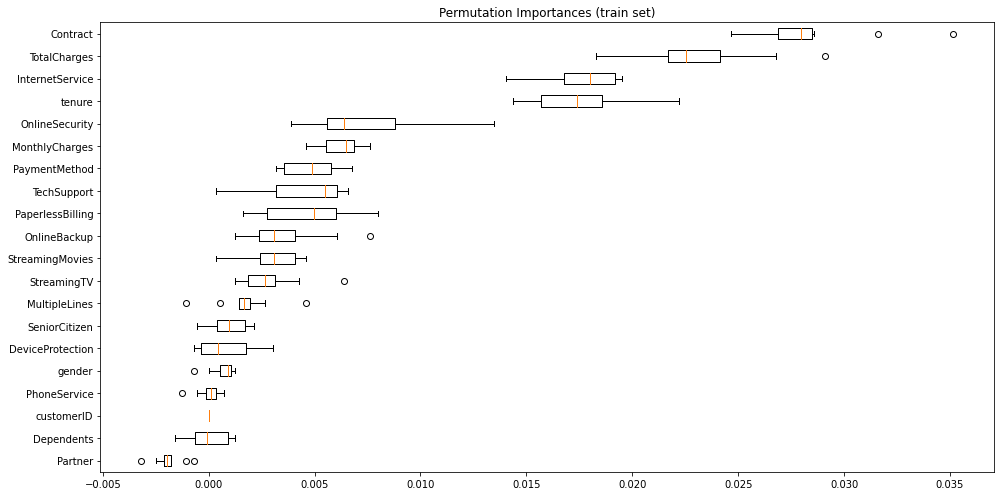

In [227]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(14,7))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

We can see that Contract, totalCharges, tenure, InternetService and OnlineSecurity are the 5 most important features.

### Recommendation:

#### As we don't know what the business wants we can make a recommendation, choosing by ourselves the desired recall.

In [228]:
precision, recall, thresholds = precision_recall_curve(le.transform(y_test), y_score[:, 1])

In [229]:
recall_desired = 0.6
idx = find_nearest(recall, recall_desired)

In [230]:
print("for a recall of {0}, we should set a threshold of: {1:0.2f} and we will get an precision of: {2:0.2f}".format(recall_desired, thresholds[idx], precision[idx]))

for a recall of 0.6, we should set a threshold of: 0.43 and we will get an precision of: 0.63


### Step by step summary:
- Load the data and do a quick analysis of the data and features available.
- Choose a research question.
- preprocess and do feature engineering over each column.
- Decide which were the best metrics to address this problem.
- Choose two different models to fit using RandomizedSearchCV for finding the best hyperparameters.
- Fit the different models unsing n_fold = 5 and compare two models metrics.
- Choose the best model and give business recommendations based on that model.

### Next steps:
- Discuss with the business which are their expectations regarding false positive and false negatives.
- Train a new model removing the least important features and compare perfomance against our current best_model. A model with less features is easier to maintain.